# AMC with MATLAB (Deep Learning toolbox)

Using the matlab jupyter kernel from [here](https://github.com/Calysto/matlab_kernel).

In this notebook we'll use MATLAB and the Deep Learning toolbox to train our AMC model.

In [1]:
ver('matlab').Release


ans =

    '(R2020b)'



## Data exploration

First lets see how we'd load a dataset and observe the dimensionality. We can see that we're dealing with 512 waveforms, each 1024 samples long.

In [2]:
data = load('./data/qpsk_data.mat').data;
whos data

  Name        Size                Bytes  Class     Attributes

  data      512x1024            8388608  double    complex   



We can also visualize our waveforms by plotting the data. 

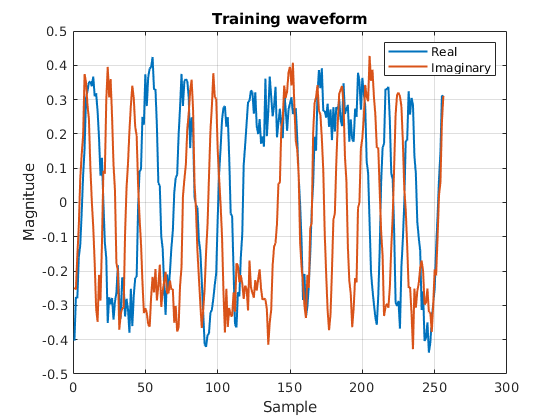

In [3]:
plot(real(data(1,1:256)), 'Linewidth', 1.5)
hold on; grid on
plot(imag(data(1,1:256)), 'Linewidth', 1.5)
title('Training waveform')
xlabel('Sample')
ylabel('Magnitude')
legend('Real', 'Imaginary')

## Prep training data

Note that our data is provided as complex numbers and conventional convolutional networks deal with real numbers. Which means we will have to split our data into real and imaginary channels - we do this in the loop with the *cat* function.

Most significant takeaways here are that the DL toolbox requires your batches to be the last index and your labels have to be cast into the matlab 'categorical' type.

In [4]:
x_train = [];
y_train = [];

myFiles = dir ('./data/*.mat');

for i = 1:size(myFiles,1)
    data = load(strcat('./data/',myFiles(i).name)).data;
    data = cat(3,real(data),imag(data)); % concat real/imag
    labels = ones(size(data,1),1)*i-1;
    
    x_train = cat(1, x_train, data);
    y_train = cat(1, y_train, labels);
end

x_train = permute(x_train, [2,3,1]);

% Sneak in a cheeky extra dimension
x_train = reshape(x_train, 1024, 2, [], 2048);

% Training labels must be cast into the special 'categorical' type before we 
% feed it to the neural net
y_train = permute(y_train, [2,1]);
y_train = categorical(y_train);

Split our training data into training and validation sets, leaving 20% of the data for validation

In [5]:
num_examples = size(x_train,4);

idx = randperm(num_examples,ceil(num_examples*0.2));

x_val = x_train(:,:,:,idx);
y_val = y_train(idx);

x_train(:,:,:,idx) = [];
y_train(idx) = [];

In [6]:
whos x_train
whos x_val

whos y_train
whos y_val

  Name            Size                     Bytes  Class     Attributes

  x_train      1024x2x1x1638            26836992  double              

  Name          Size                   Bytes  Class     Attributes

  x_val      1024x2x1x410            6717440  double              

  Name         Size              Bytes  Class          Attributes

  y_train      1x1638             2064  categorical              

  Name       Size             Bytes  Class          Attributes

  y_val      1x410              836  categorical              



## Train model

First define the architecture by creating a list of layers.

In [7]:
layers = [
    imageInputLayer([1024 2 1])

    convolution2dLayer([16 2],8,'Padding',0)
    reluLayer

    convolution2dLayer([16 1],4,'Padding',0)
    reluLayer
    
    fullyConnectedLayer(120)
    reluLayer
    
    fullyConnectedLayer(84)
    reluLayer

    fullyConnectedLayer(4)
    softmaxLayer
    classificationLayer];

Specify some training options, trying to keep things same as our Python notebooks.

In [8]:
options = trainingOptions('adam', ...
    'MaxEpochs',5, ...
    'MiniBatchSize', 32, ...
    'ValidationData', {x_val, y_val}, ...
    'ValidationFrequency', 32, ...
    'Verbose',true, ...
    'Shuffle', 'every-epoch');

However you should keep in mind that in MATLAB there are oftentimes parameters preset that you may or may not want to have. Always make sure to explore these structures to find out what's preset. E.g. L2 regularization is already defined in the options, as well as learn rate schedulers. They're good things to have and considered good practice, but it's easy to get caught off guard when trying to recreate a result from a different library.

In [9]:
options


options = 

  TrainingOptionsADAM with properties:

           GradientDecayFactor: 0.9000
    SquaredGradientDecayFactor: 0.9990
                       Epsilon: 1.0000e-08
              InitialLearnRate: 1.0000e-03
             LearnRateSchedule: 'none'
           LearnRateDropFactor: 0.1000
           LearnRateDropPeriod: 10
              L2Regularization: 1.0000e-04
       GradientThresholdMethod: 'l2norm'
             GradientThreshold: Inf
                     MaxEpochs: 5
                 MiniBatchSize: 32
                       Verbose: 1
              VerboseFrequency: 50
                ValidationData: {[1024x2x1x410 double]  [1x410 categorical]}
           ValidationFrequency: 32
            ValidationPatience: Inf
                       Shuffle: 'every-epoch'
                CheckpointPath: ''
          ExecutionEnvironment: 'auto'
                    WorkerLoad: []
                     OutputFcn: []
                         Plots: 'none'
                SequenceLength: 'lo

Now train the network. If you specify a second output *info*, you can grab the training information for plotting as well.

In [10]:
[net, info] = trainNetwork(x_train, y_train, layers, options);

Training on single GPU.
Initializing input data normalization.
|======================================================================================================================|
|  Epoch  |  Iteration  |  Time Elapsed  |  Mini-batch  |  Validation  |  Mini-batch  |  Validation  |  Base Learning  |
|         |             |   (hh:mm:ss)   |   Accuracy   |   Accuracy   |     Loss     |     Loss     |      Rate       |
|======================================================================================================================|
|       1 |           1 |       00:00:01 |       18.75% |       25.61% |       1.3750 |       1.2883 |          0.0010 |
|       1 |          32 |       00:00:01 |       84.38% |       76.83% |       0.2665 |       0.3107 |          0.0010 |
|       1 |          50 |       00:00:02 |       96.88% |              |       0.1681 |              |          0.0010 |
|       2 |          64 |       00:00:02 |       93.75% |       99.51% |       0.0769 |   

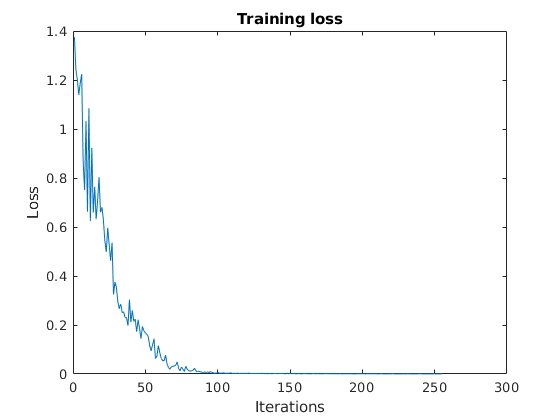

In [11]:
plot(info.TrainingLoss)
title('Training loss')
xlabel('Iterations')
ylabel('Loss')